# üé® Day 3.2 - Data Augmentation Pipeline

## üéØ Learning Objectives

In this notebook, you'll learn:
1. **What is data augmentation** and why it's crucial
2. **Which augmentations** work for medical images
3. **How to build a data pipeline** using Keras ImageDataGenerator
4. **Visualize augmentations** to ensure they're realistic

---

## üß† Theory: Why Data Augmentation?

### Problems We're Solving:

1. **Limited Dataset Size** (~3066 images)
   - Deep learning models need thousands/millions of samples
   - Augmentation artificially expands dataset

2. **Overfitting Risk**
   - Model memorizes training data instead of learning patterns
   - Augmentation forces model to be invariant to transformations

3. **Class Imbalance** (Class 2 is ~2√ó larger)
   - Augmentation can help balance classes during training

4. **Real-world Variability**
   - MRI scans have different orientations, positions, brightness
   - Augmentation simulates this variability

---

## üîÑ Augmentation Techniques for Medical Images

### ‚úÖ **Safe Augmentations** (preserve medical meaning):
- **Rotation** (¬±15¬∞): Patient head can be tilted
- **Width/Height Shift** (5%): Slight repositioning
- **Zoom** (10%): Different scan distances
- **Horizontal Flip**: Brain is roughly symmetric

### ‚ùå **Unsafe Augmentations** (can change diagnosis):
- **Vertical Flip**: Brain anatomy is not vertically symmetric
- **Large Rotations** (>30¬∞): Unrealistic orientation
- **Color Jittering**: Grayscale MRI, intensity has meaning
- **Extreme Distortions**: Could alter tumor appearance

---

## üîß Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
import os

# Check TensorFlow GPU support
import tensorflow as tf
print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")
print(f"CUDA Available: {tf.test.is_built_with_cuda()}")

# Set style
sns.set_style('white')
plt.rcParams['figure.figsize'] = (15, 5)

print("\n‚úÖ Libraries imported successfully")

2025-10-22 11:33:55.910673: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


TensorFlow version: 2.20.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
CUDA Available: True

‚úÖ Libraries imported successfully


## üìÇ Load Split Data

In [2]:
# Load splits
train_meta = pd.read_csv('../../outputs/data_splits/train_split.csv')
val_meta = pd.read_csv('../../outputs/data_splits/val_split.csv')
test_meta = pd.read_csv('../../outputs/data_splits/test_split.csv')

# Convert labels to strings (required by ImageDataGenerator)
train_meta['label'] = train_meta['label'].astype(str)
val_meta['label'] = val_meta['label'].astype(str)
test_meta['label'] = test_meta['label'].astype(str)

print(f"üìä Data Loaded:")
print(f"  Train: {len(train_meta)} images")
print(f"  Val:   {len(val_meta)} images")
print(f"  Test:  {len(test_meta)} images")

print(f"\nColumns: {train_meta.columns.tolist()}")
print(f"Label dtype: {train_meta['label'].dtype}")
train_meta.head()

üìä Data Loaded:
  Train: 2059 images
  Val:   325 images
  Test:  680 images

Columns: ['filename', 'label', 'patient_id', 'original_mat_name', 'filepath']
Label dtype: object


filename label patient_id  original_mat_name  \
0  pid101029_1465.png     3     101029               1465   
1  pid105187_1561.png     3     105187               1561   
2  pid112746_1003.png     3     112746               1003   
3  pid114094_1024.png     3     114094               1024   
4  pid112746_1258.png     3     112746               1258   

                                            filepath  
0  ../../outputs/ce_mri_enhanced/3/pid101029_1465...  
1  ../../outputs/ce_mri_enhanced/3/pid105187_1561...  
2  ../../outputs/ce_mri_enhanced/3/pid112746_1003...  
3  ../../outputs/ce_mri_enhanced/3/pid114094_1024...  
4  ../../outputs/ce_mri_enhanced/3/pid112746_1258...

## üé® Configure Augmentation Parameters

In [3]:
# Define augmentation for TRAINING data
train_datagen = ImageDataGenerator(
    rescale=1./255,              # Normalize pixel values to [0, 1]
    rotation_range=15,           # Random rotation ¬±15 degrees
    width_shift_range=0.05,      # Horizontal shift up to 5%
    height_shift_range=0.05,     # Vertical shift up to 5%
    zoom_range=0.1,              # Zoom in/out up to 10%
    horizontal_flip=True,        # Random horizontal flip
    vertical_flip=False,         # NO vertical flip (not anatomically valid)
    fill_mode='nearest'          # How to fill pixels after transformations
)

# Define augmentation for VALIDATION/TEST data (only normalization)
val_test_datagen = ImageDataGenerator(
    rescale=1./255               # Only normalize, no augmentation
)

print("‚úÖ Data generators configured")
print("\nüìù Training augmentations:")
print("  - Rescale: 0-1")
print("  - Rotation: ¬±15¬∞")
print("  - Shift: ¬±5%")
print("  - Zoom: ¬±10%")
print("  - Horizontal flip: Yes")
print("\nüìù Val/Test: Only rescaling (no augmentation)")

‚úÖ Data generators configured

üìù Training augmentations:
  - Rescale: 0-1
  - Rotation: ¬±15¬∞
  - Shift: ¬±5%
  - Zoom: ¬±10%
  - Horizontal flip: Yes

üìù Val/Test: Only rescaling (no augmentation)


## üîÑ Create Data Generators

In [4]:
# Training generator
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_meta,
    x_col='filepath',
    y_col='label',
    target_size=(128, 128),      # Resize all images to 128x128
    color_mode='grayscale',      # Single channel (grayscale)
    class_mode='categorical',    # One-hot encoded labels
    batch_size=32,
    shuffle=True,                # Shuffle for training
    seed=42
)

print("‚úÖ Training generator created")
print(f"  Batches per epoch: {len(train_generator)}")
print(f"  Classes found: {train_generator.class_indices}")

Found 2059 validated image filenames belonging to 3 classes.
‚úÖ Training generator created
  Batches per epoch: 65
  Classes found: {'1': 0, '2': 1, '3': 2}


In [6]:
# Validation generator
val_generator = val_test_datagen.flow_from_dataframe(
    dataframe=val_meta,
    x_col='filepath',
    y_col='label',
    target_size=(128, 128),
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=32,
    shuffle=False,               # Don't shuffle validation
    seed=42
)

print("‚úÖ Validation generator created")
print(f"  Batches: {len(val_generator)}")

Found 325 validated image filenames belonging to 3 classes.
‚úÖ Validation generator created
  Batches: 11


In [5]:
# Test generator (we'll use this on Day 4)
test_generator = val_test_datagen.flow_from_dataframe(
    dataframe=test_meta,
    x_col='filepath',
    y_col='label',
    target_size=(128, 128),
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=32,
    shuffle=False,
    seed=42
)

print("‚úÖ Test generator created")
print(f"  Batches: {len(test_generator)}")

Found 680 validated image filenames belonging to 3 classes.
‚úÖ Test generator created
  Batches: 22


## üîç Inspect a Batch

In [6]:
# Get one batch from training generator
x_batch, y_batch = next(train_generator)

print("üì¶ Batch Information:")
print(f"  Image batch shape: {x_batch.shape}")  # (batch_size, height, width, channels)
print(f"  Label batch shape: {y_batch.shape}")  # (batch_size, num_classes)
print(f"  Image dtype: {x_batch.dtype}")
print(f"  Image value range: [{x_batch.min():.3f}, {x_batch.max():.3f}]")
print(f"\n  First label (one-hot): {y_batch[0]}")
print(f"  First label (class): {np.argmax(y_batch[0]) + 1}")  # +1 because classes are 1,2,3

üì¶ Batch Information:
  Image batch shape: (32, 128, 128, 1)
  Label batch shape: (32, 3)
  Image dtype: float32
  Image value range: [0.000, 0.997]

  First label (one-hot): [0. 1. 0.]
  First label (class): 2


## üëÅÔ∏è Visualize Augmentations

Let's see how augmentation transforms a single image

In [7]:
# Pick a sample image
sample_path = train_meta.iloc[42]['filepath']  # Random choice
sample_label = train_meta.iloc[42]['label']

# Load and preprocess
from tensorflow.keras.preprocessing.image import load_img, img_to_array

img = load_img(sample_path, target_size=(128, 128), color_mode='grayscale')
img_array = img_to_array(img)
img_array = img_array.reshape((1,) + img_array.shape)  # (1, 128, 128, 1)

print(f"Sample image: {sample_path}")
print(f"Label: Class {sample_label}")

Sample image: ../../outputs/ce_mri_enhanced/3/pid104019_1351.png
Label: Class 3


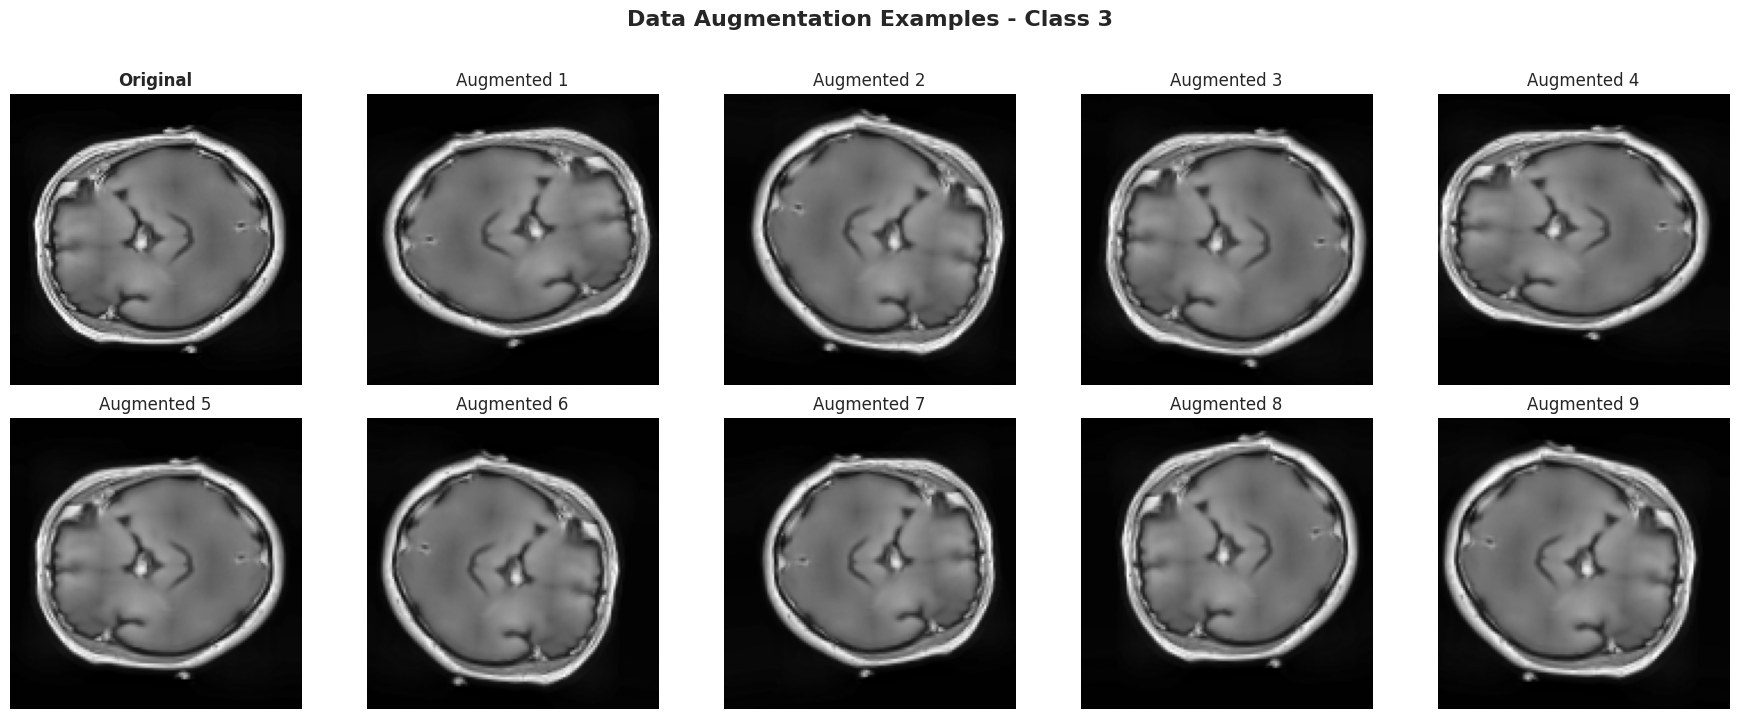

‚úÖ Augmentation visualization saved


In [8]:
# Generate augmented versions
fig, axes = plt.subplots(2, 5, figsize=(18, 7))
axes = axes.ravel()

# Original
axes[0].imshow(img, cmap='gray')
axes[0].set_title('Original', fontsize=12, fontweight='bold')
axes[0].axis('off')

# Generate 9 augmented versions
aug_generator = train_datagen.flow(img_array, batch_size=1, seed=None)

for i in range(1, 10):
    aug_img = next(aug_generator)[0]
    axes[i].imshow(aug_img.squeeze(), cmap='gray')
    axes[i].set_title(f'Augmented {i}', fontsize=12)
    axes[i].axis('off')

plt.suptitle(f'Data Augmentation Examples - Class {sample_label}', 
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('../../outputs/visualizations/day3_02_augmentation_examples.png', 
            dpi=150, bbox_inches='tight')
plt.show()

print("‚úÖ Augmentation visualization saved")

## üìä Visualize Sample Batch

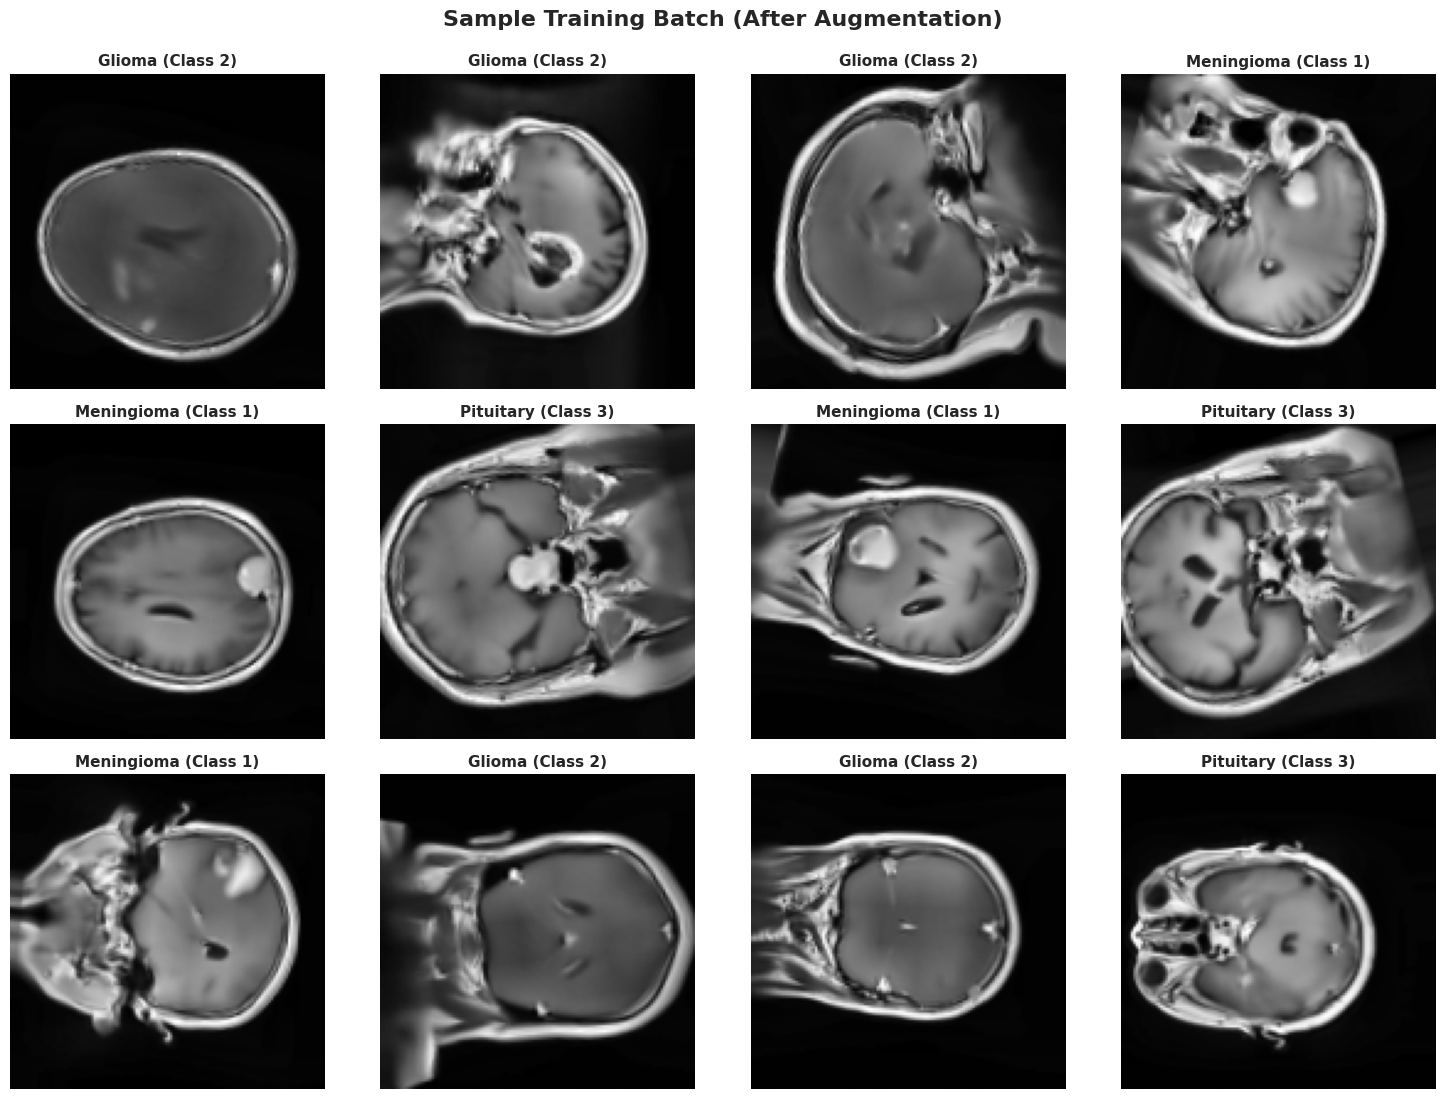

‚úÖ Batch visualization saved


In [9]:
# Get a fresh batch
x_batch, y_batch = next(train_generator)

# Map class indices back to labels
class_names = {0: 'Meningioma', 1: 'Glioma', 2: 'Pituitary'}

# Display first 12 images
fig, axes = plt.subplots(3, 4, figsize=(15, 11))
axes = axes.ravel()

for i in range(12):
    axes[i].imshow(x_batch[i].squeeze(), cmap='gray')
    class_idx = np.argmax(y_batch[i])
    axes[i].set_title(f'{class_names[class_idx]} (Class {class_idx + 1})', 
                      fontsize=11, fontweight='bold')
    axes[i].axis('off')

plt.suptitle('Sample Training Batch (After Augmentation)', 
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('../../outputs/visualizations/day3_02_training_batch.png', 
            dpi=150, bbox_inches='tight')
plt.show()

print("‚úÖ Batch visualization saved")

## ‚öñÔ∏è Check Class Distribution in Batches

üìä Class distribution in 10 batches:
  Class 1 (Meningioma): 72 (22.5%)
  Class 2 (Glioma): 140 (43.8%)
  Class 3 (Pituitary): 108 (33.8%)


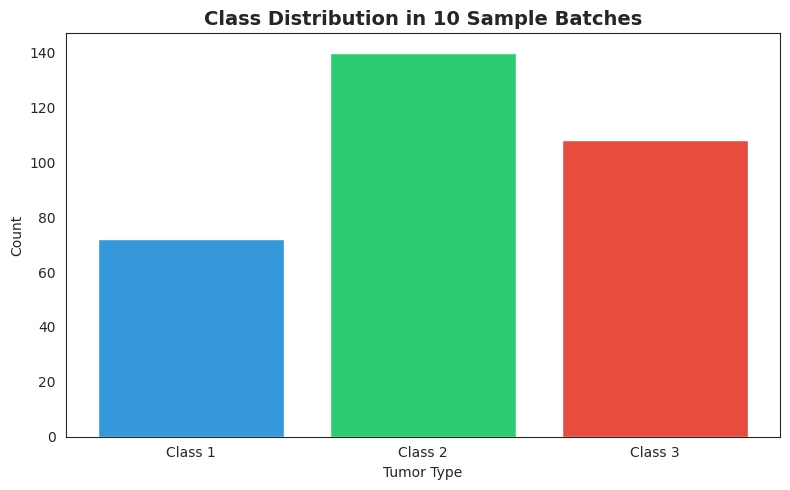


‚úÖ Distribution visualization saved


In [10]:
# Sample 10 batches and check class distribution
class_counts = {0: 0, 1: 0, 2: 0}
n_batches = 10

for _ in range(n_batches):
    _, y_batch = next(train_generator)
    for label in y_batch:
        class_idx = np.argmax(label)
        class_counts[class_idx] += 1

print(f"üìä Class distribution in {n_batches} batches:")
for class_idx, count in class_counts.items():
    percentage = count / sum(class_counts.values()) * 100
    print(f"  Class {class_idx + 1} ({class_names[class_idx]}): {count} ({percentage:.1f}%)")

# Visualize
plt.figure(figsize=(8, 5))
plt.bar([f"Class {i+1}" for i in class_counts.keys()], 
        list(class_counts.values()),
        color=['#3498db', '#2ecc71', '#e74c3c'])
plt.title(f'Class Distribution in {n_batches} Sample Batches', 
          fontsize=14, fontweight='bold')
plt.ylabel('Count')
plt.xlabel('Tumor Type')
plt.tight_layout()
plt.savefig('../../outputs/visualizations/day3_02_batch_distribution.png', 
            dpi=150, bbox_inches='tight')
plt.show()

print("\n‚úÖ Distribution visualization saved")

## üî¨ Compare Original vs Augmented

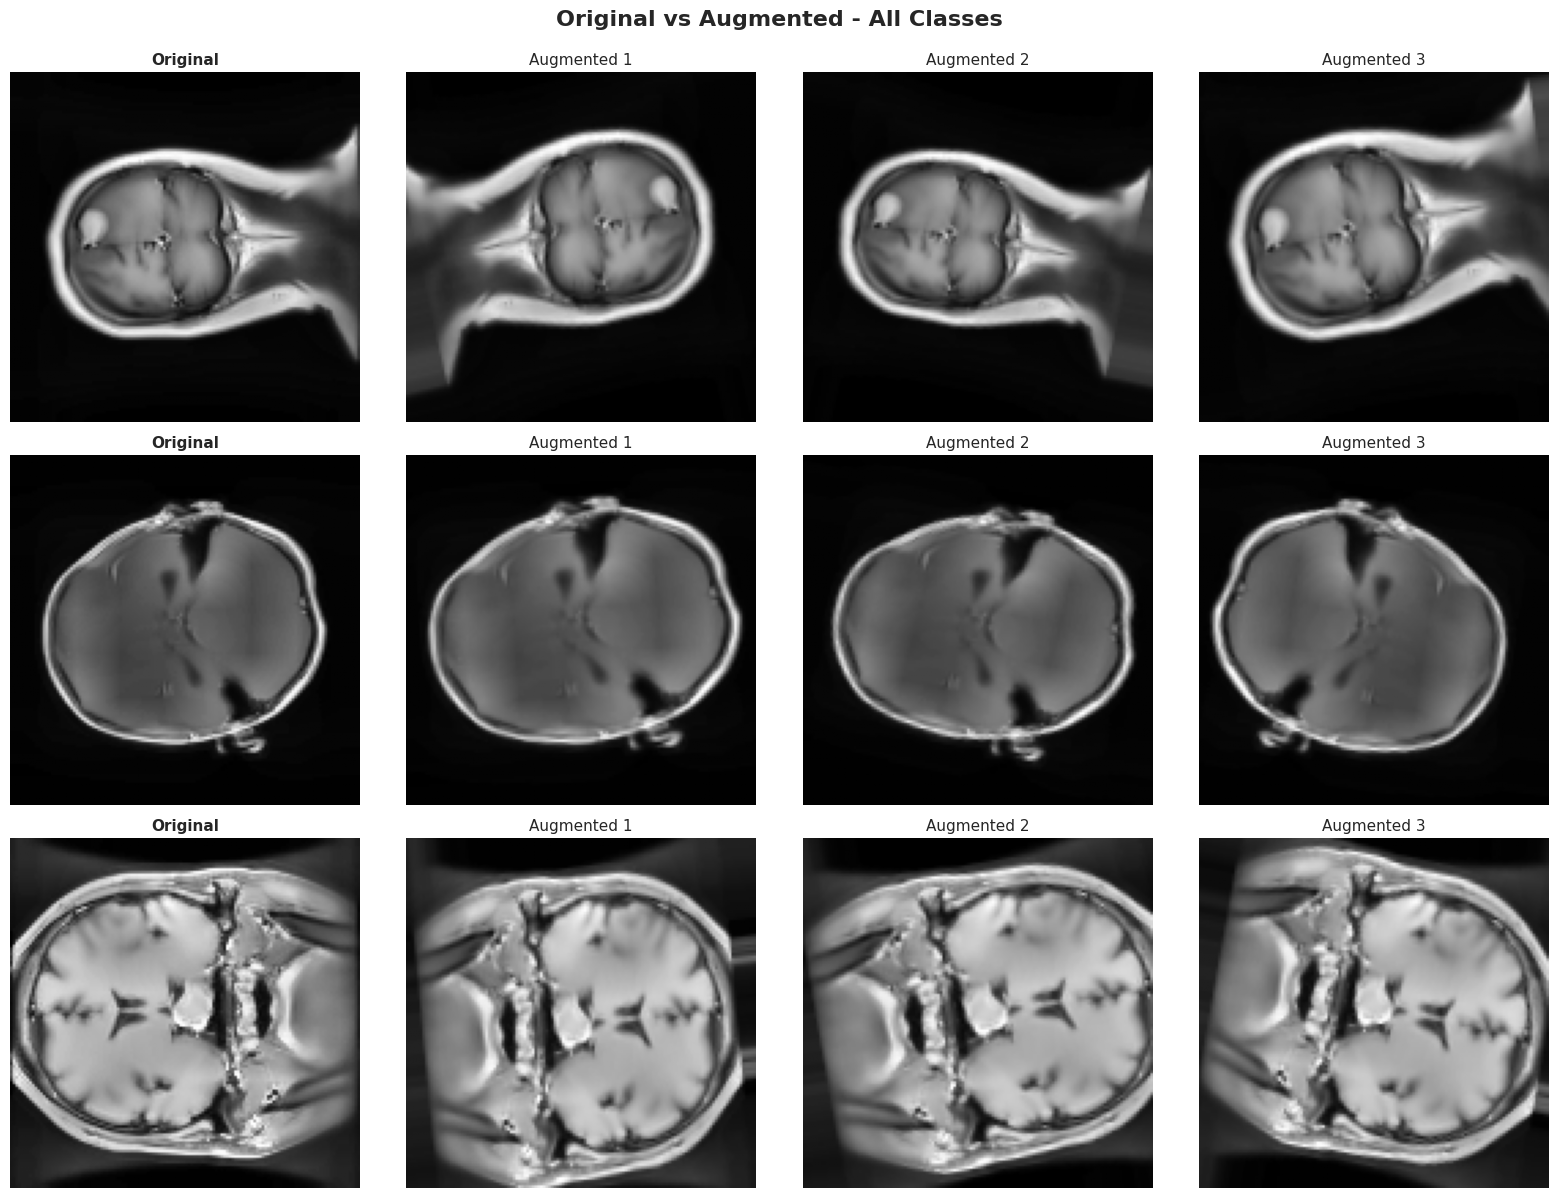

‚úÖ Class comparison saved


In [11]:
# Compare side-by-side for each class
fig, axes = plt.subplots(3, 4, figsize=(16, 12))

for class_idx in range(3):
    # Find sample from this class
    class_sample = train_meta[train_meta['label'] == str(class_idx + 1)].iloc[0]
    img_path = class_sample['filepath']
    
    # Load original
    img = load_img(img_path, target_size=(128, 128), color_mode='grayscale')
    img_array = img_to_array(img)
    img_array = img_array.reshape((1,) + img_array.shape)
    
    # Original
    axes[class_idx, 0].imshow(img, cmap='gray')
    axes[class_idx, 0].set_title('Original', fontsize=11, fontweight='bold')
    axes[class_idx, 0].set_ylabel(f'{class_names[class_idx]}\n(Class {class_idx + 1})', 
                                   fontsize=12, fontweight='bold')
    axes[class_idx, 0].axis('off')
    
    # Generate 3 augmented versions
    aug_gen = train_datagen.flow(img_array, batch_size=1)
    for j in range(1, 4):
        aug_img = next(aug_gen)[0]
        axes[class_idx, j].imshow(aug_img.squeeze(), cmap='gray')
        axes[class_idx, j].set_title(f'Augmented {j}', fontsize=11)
        axes[class_idx, j].axis('off')

plt.suptitle('Original vs Augmented - All Classes', 
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('../../outputs/visualizations/day3_02_all_classes_augmentation.png', 
            dpi=150, bbox_inches='tight')
plt.show()

print("‚úÖ Class comparison saved")

## üíæ Save Generator Configuration

We'll save the parameters for reproducibility and documentation

In [12]:
os.makedirs('../../outputs/configs', exist_ok=True)

# Document augmentation parameters
aug_config = {
    'target_size': (128, 128),
    'color_mode': 'grayscale',
    'batch_size': 32,
    'class_mode': 'categorical',
    'train_augmentation': {
        'rescale': 1./255,
        'rotation_range': 15,
        'width_shift_range': 0.05,
        'height_shift_range': 0.05,
        'zoom_range': 0.1,
        'horizontal_flip': True,
        'vertical_flip': False,
        'fill_mode': 'nearest'
    },
    'val_test_augmentation': {
        'rescale': 1./255
    },
    'num_classes': 3,
    'class_names': ['Meningioma', 'Glioma', 'Pituitary']
}

import json
with open('../../outputs/configs/augmentation_config.json', 'w') as f:
    json.dump(aug_config, f, indent=2)

print("‚úÖ Augmentation configuration saved to augmentation_config.json")

‚úÖ Augmentation configuration saved to augmentation_config.json


## üìù Summary

### ‚úÖ What We Accomplished:

1. **Created Training Data Generator**
   - Augmentation: rotation (¬±15¬∞), shift (5%), zoom (10%), horizontal flip
   - Normalization: pixel values scaled to [0, 1]
   - Batch size: 32

2. **Created Val/Test Data Generators**
   - Only normalization (no augmentation)
   - Ensures fair evaluation

3. **Verified Data Pipeline**
   - Correct shapes: (32, 128, 128, 1)
   - Proper normalization: [0, 1]
   - Class balance maintained

4. **Visualized Augmentations**
   - Realistic transformations
   - Preserves anatomical structure
   - Increases diversity

---

### üéì Key Insights:

- **On-the-fly augmentation**: ImageDataGenerator applies transformations during training, saving disk space
- **Medical image considerations**: Avoided vertical flips and extreme distortions
- **Validation/test integrity**: No augmentation on evaluation sets

---

### üöÄ Next Steps:
Move to **day3_03_cnn_architecture.ipynb** to design the CNN model!